## Breast Cancer Wisconsin Data
#### https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data

##### Combining random forest with neural network to detect if a tumor is malign or benign

#### Data Preprocessing


In [45]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')
df.head()

df.drop('id', axis=1, inplace=True) #drop id column

df.loc[df["diagnosis"] == "B", "diagnosis"] = 0
df.loc[df["diagnosis"] == "M", "diagnosis"] = 1

#### Plotting the data

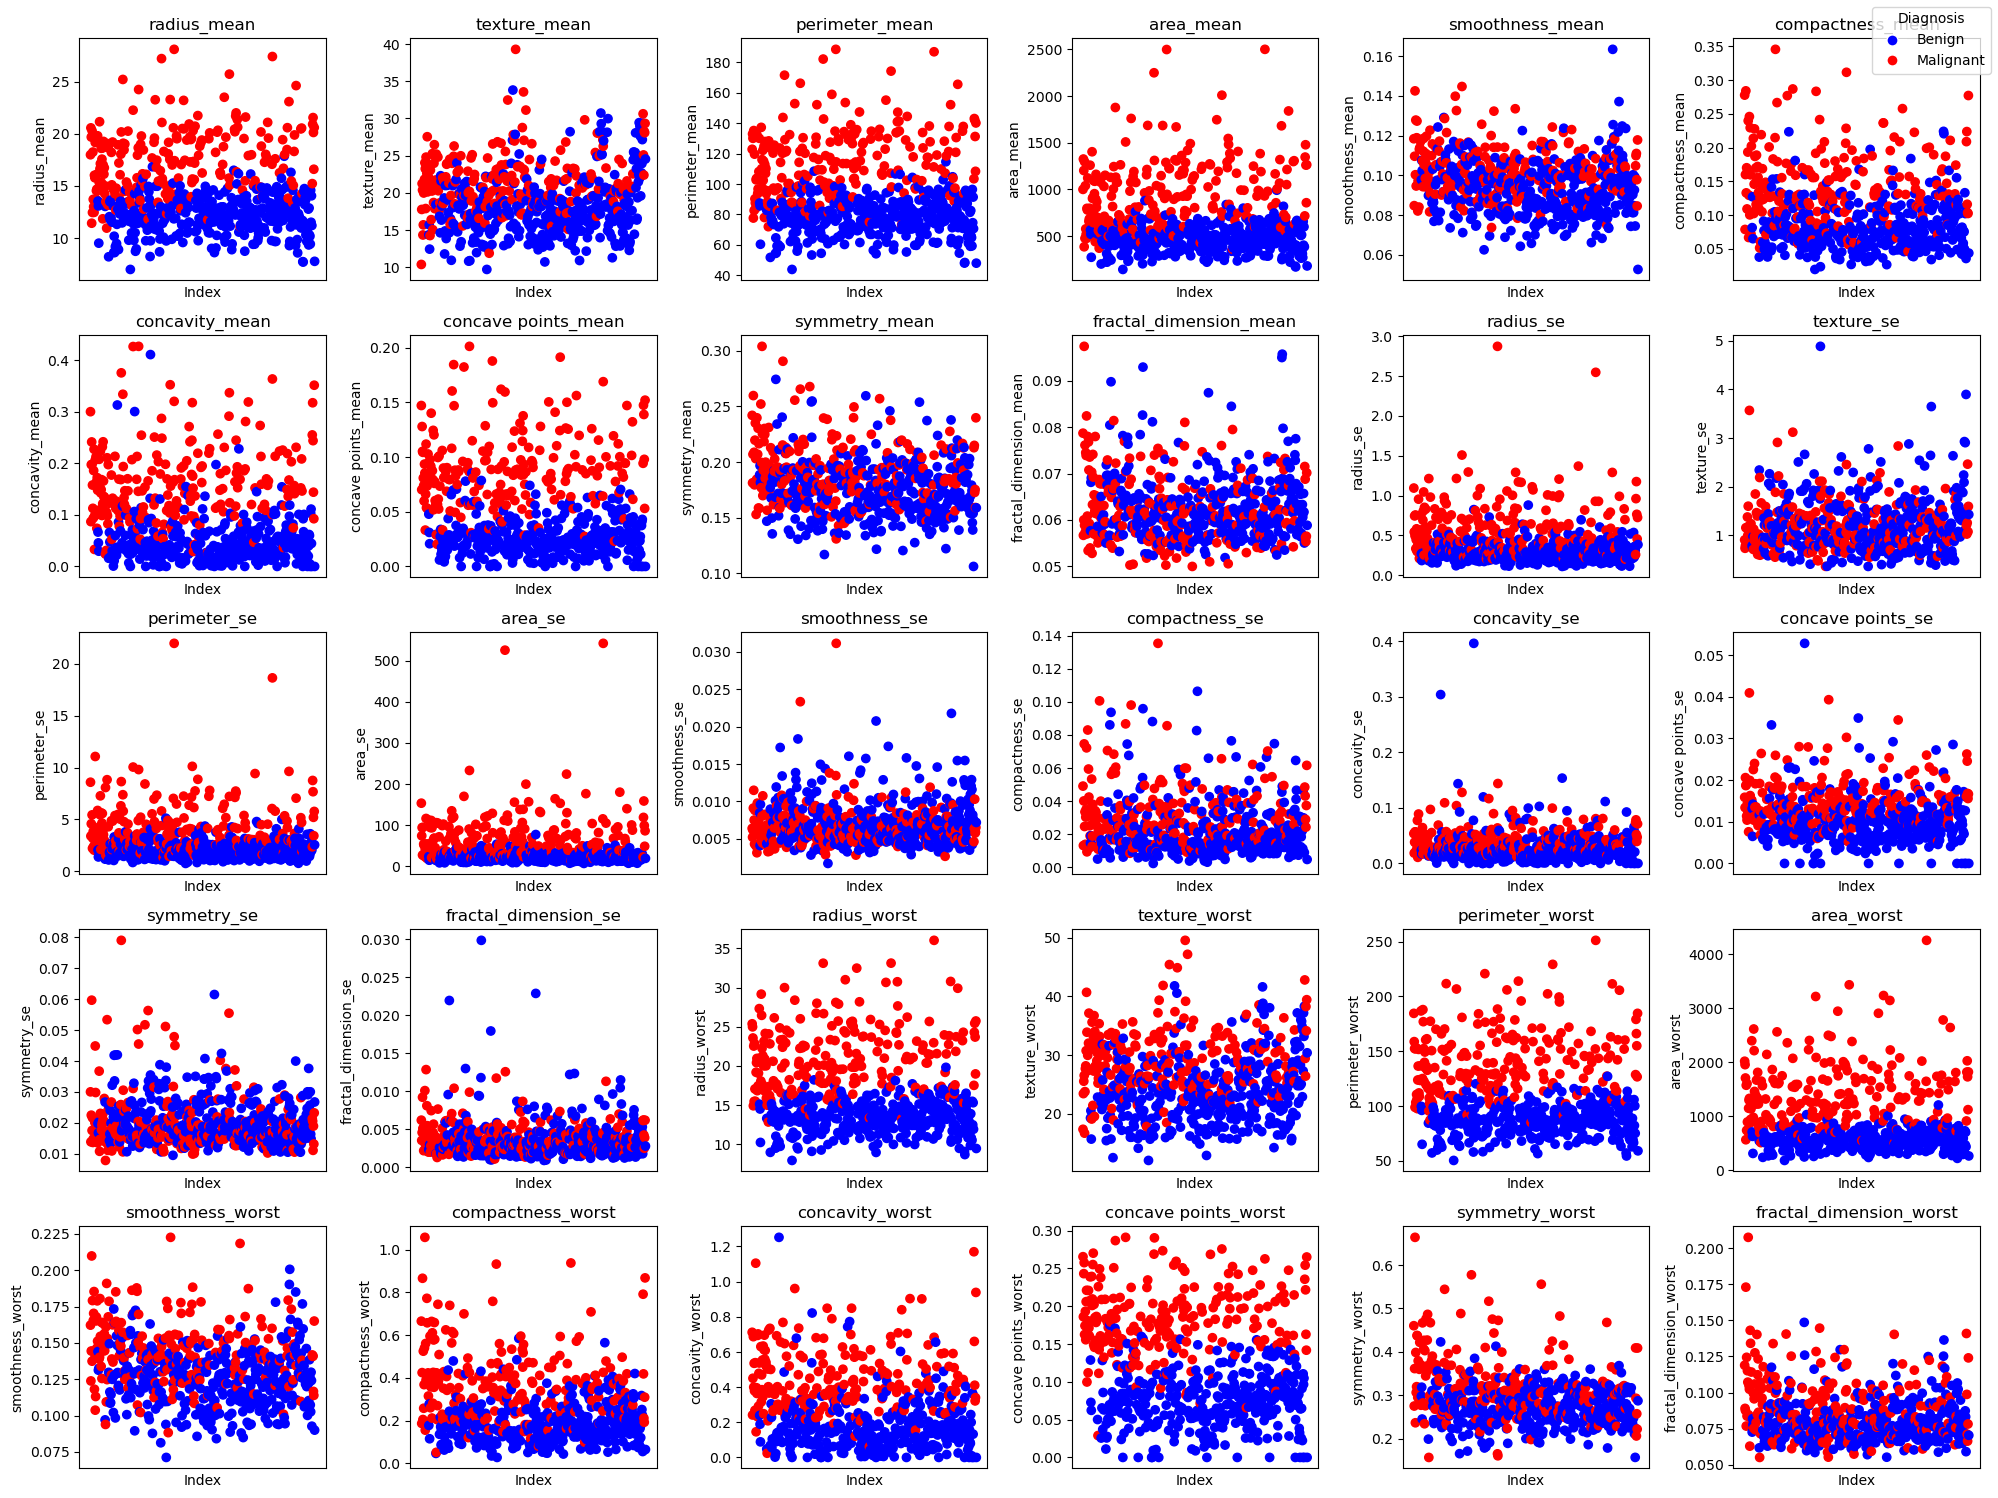

In [46]:
colors = df['diagnosis'].map({0: 'blue', 1: 'red'})

# Create subplots: 5 rows x 6 columns
fig, axes = plt.subplots(5, 6, figsize=(20, 15))  
# Flatten axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(df.columns[1:-1]):  # Exclude the first 'diagnosis' column
    axes[i].scatter(df.index, df[column], c=colors)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(column)
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-ticks for cleaner look

# Add custom handles and labels for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Benign'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Malignant')]

# Add a single legend for all subplots
fig.legend(handles=handles, title="Diagnosis", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Further Processing

In [49]:
df = df.drop(columns=['Unnamed: 32'], errors='ignore')
perct_malign = np.sum(df["diagnosis"] == 1) / df.shape[0]
perct_benign = np.sum(df["diagnosis"] == 0) / df.shape[0]
print("Perct malign:" , perct_malign ,"Perct benign:" ,  perct_benign)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Separate features (X) and target (y)
X = df.iloc[:, 1:]  # All columns except 'diagnosis'

y = df['diagnosis'].values  # 'diagnosis' should be binary

# Initialize the label encoder if the diagnosis column isn't already 0/1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



Perct malign: 0.37258347978910367 Perct benign: 0.6274165202108963


#### Training the DT

In [105]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy' ]
}


dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_dt = grid_search.best_estimator_


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9473


In [127]:
y_pred_dt = best_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test,y_pred_dt))
test_accuracy_dt = accuracy_score(y_test,y_pred_dt)
print(test_accuracy_dt)

              precision    recall  f1-score   support

           0       0.95      0.86      0.91        72
           1       0.80      0.93      0.86        42

    accuracy                           0.89       114
   macro avg       0.87      0.89      0.88       114
weighted avg       0.90      0.89      0.89       114

[[62 10]
 [ 3 39]]
0.8859649122807017


#### Training the NN

C:\Users\Cihan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Axes: title={'center': 'Accuracy'}>

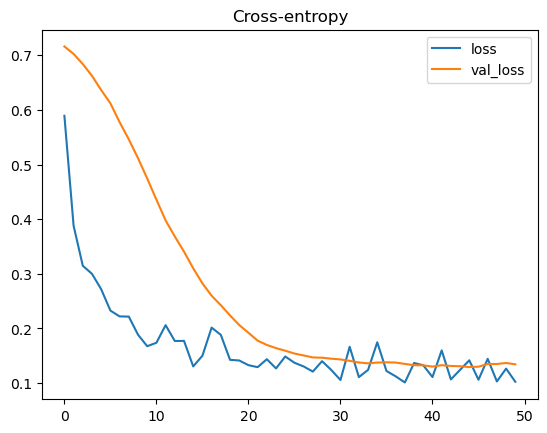

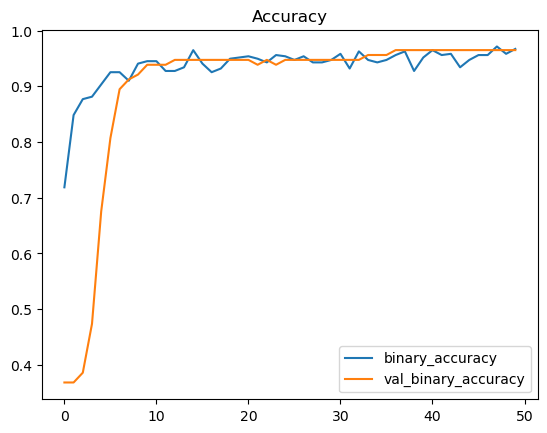

In [98]:
from tensorflow import keras
from tensorflow.keras import layers


input_shape = [X_train.shape[1]]

model = model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    
    layers.Dense(10, activation='sigmoid'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(20, activation='sigmoid'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid'),
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['binary_accuracy']
)


early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.00001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    callbacks=[early_stopping],
    verbose= 0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred_nn = model.predict(X_test)
y_pred_classes_nn = (y_pred_nn > 0.5).astype(int)  # Convert probabilities to binary predictions
print(classification_report(y_test, y_pred_classes_nn))
print(confusion_matrix(y_test,y_pred_classes_nn))
test_accuracy_nn = accuracy_score(y_test,y_pred_classes_nn)
print(test_accuracy_nn)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

[[72  0]
 [ 4 38]]
0.9649122807017544


##### Combining Both Models
##### I will use voting method each model will have its own weight
##### To find the best params $w1$, $w2$ I will use exhaustive search
##### error metric will be negative binary cross entropy

In [133]:
from sklearn.metrics import log_loss
def combined_predict(w1, w2, p1, p2):
    return (w1 * p1 + w2 * p2) 

best_score = np.inf
best_params = (0, 0)

for w1 in np.arange(0.1, 1.1, 0.05):
    for w2 in np.arange(0.1, 1.1, 0.05):
        # Combine predictions
        y_pred_comb_prob = combined_predict(w1, w2, p1, p2)
        y_pred_comb_classes = (y_pred_comb_prob > 0.5).astype(int)
        
        # Calculate accuracy
        score = log_loss(y_test, y_pred_comb_classes)
        
        # Check if this is the best score
        if score < best_score:
            best_score = score
            best_params = (w1, w2)

# Print the best parameters and score
print(f'Best parameters: w1 = {best_params[0]}, w2 = {best_params[1]}')
print(f'Best binary log loss score: {best_score:.4f}')

# Combine predictions using the best weights
y_pred_comb_prob = combined_predict(best_params[0], best_params[1], p1, p2)
y_pred_comb_classes = (y_pred_comb_prob > 0.5).astype(int)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_comb_classes))
print(confusion_matrix(y_test, y_pred_comb_classes))

# Calculate and print accuracy
test_accuracy_comb = accuracy_score(y_test, y_pred_comb_classes)
print(f'Combined Model Test Accuracy: {test_accuracy_comb:.4f}')


Best parameters: w1 = 0.1, w2 = 0.9500000000000003
Best binary log loss score: 0.9485
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

[[72  0]
 [ 3 39]]
Combined Model Test Accuracy: 0.9737
